## Fu: load reference data

In [1]:
import scanpy as sc
import anndata
from scipy import io
from scipy.sparse import coo_matrix, csr_matrix
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

In [2]:
import warnings
warnings.filterwarnings("ignore")

#### create colormap for UMAPs

In [3]:
# list of HEX colors
hex_colors = ["#D90254", "#343AAD", "#04B2C6", "#73AF2A", "#FDB81E", "#5F3530", "#7F009E", "#0B7CE3",
              "#088775", "#C0D33C", "#FB8606", "#888888", "#582399", "#269CFC", "#39A240"]

# convert HEX colors to RGB
rgb_colors = [(int(color[1:3], 16)/255, int(color[3:5], 16)/255, int(color[5:7], 16)/255) for color in hex_colors]

# create colormap
cmap = ListedColormap(rgb_colors)

# create dictionary to assign colors to clusters
clusters = ["c01", "c02", "c03", "c04", "c05", "c06", "c07", "c08", "c09", "c10", "c11", "c12", "c13", "c14", "c15"]
umap_colors = {}
i = 0
for cluster in clusters:
    umap_colors[cluster] = cmap.colors[i]
    i+=1

### load data

In [4]:
X = io.mmread("../data/ref_norm_counts.mtx")
adata = anndata.AnnData(X=X.transpose().tocsr())

cell_meta = pd.read_csv("../data/ref_metadata.csv")

with open("../data/ref_gene_names.csv", 'r') as f:
    gene_names = f.read().splitlines()

# add metadata
adata.obs = cell_meta
adata.obs.index = adata.obs['barcode']
adata.var.index = gene_names

# add HVGs
hvg = pd.read_csv("../data/ref_hvg.csv")
variable_mask = [gene in hvg.values for gene in adata.var_names.tolist()]
adata.var['highly_variable'] = variable_mask

# add PCA
pca = pd.read_csv("../data/ref_pca.csv")
pca.index = adata.obs.index
adata.obsm['X_pca'] = pca.to_numpy()

# add UMAP
adata.obsm['X_umap'] = np.vstack((adata.obs['UMAP_1'].to_numpy(), adata.obs['UMAP_2'].to_numpy())).T

# add raw count data
adata.layers["counts"] = io.mmread("../data/ref_raw_counts.mtx").transpose().tocsr()

In [5]:
adata

AnnData object with n_obs × n_vars = 51504 × 22684
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'pos', 'mt', 'clonotype', 'pre', 'post', 'pre_post', 'categories', 'nCount_SCT', 'nFeature_SCT', 'immune', 'L1', 'L2', 'L3', 'L4', 'L5', 'L6', 'L7', 'L8', 'L9', 'L10', 'L11', 'L12', 'L13', 'L14', 'L15', 'L16', 'L17', 'L18', 'integrated_snn_res.0.5', 'seurat_clusters', 'integrated_snn_res.0.6', 'groups', 'repos', 'cate', 'cat', 'barcode', 'UMAP_1', 'UMAP_2'
    var: 'highly_variable'
    obsm: 'X_pca', 'X_umap'
    layers: 'counts'

### UMAP

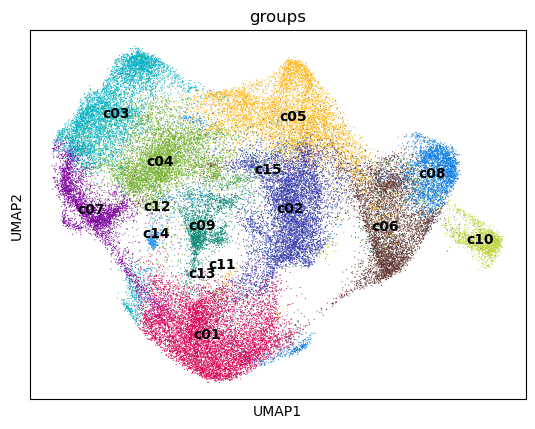

In [6]:
# plot UMAP
sc.pl.umap(adata, color="groups", dimensions=(0,1), palette=umap_colors, legend_loc='on data')

### save

In [6]:
# save
adata.write_h5ad(filename="../data/fu_ref.h5ad")